In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def entry_stop_gradients(target, mask):
    mask_stop = tf.logical_not(mask)
    mask = tf.cast(mask, dtype=target.dtype)
    mask_stop = tf.cast(mask_stop, dtype=target.dtype)
    return tf.stop_gradient(mask_stop * target) + mask * target


class affine_coupling(layers.Layer):
    def __init__(self, name, n_split_at, n_width=32, flow_coupling=0, **kwargs):
        super(affine_coupling, self).__init__(name=name, **kwargs)
        self.n_split_at = n_split_at
        self.flow_coupling = flow_coupling
        self.n_width = n_width

    def build(self, input_shape):
        n_length = input_shape[-1]
        if self.flow_coupling == 0:
            self.f = NN2('a2b', self.n_width, n_length-self.n_split_at)
        elif self.flow_coupling == 1:
            self.f = NN2('a2b', self.n_width, (n_length-self.n_split_at)*2)
        else:
            raise Exception()
        self.log_gamma = self.add_weight(name='log_gamma', shape=(
            1, n_length-self.n_split_at), initializer=tf.zeros_initializer(), dtype=tf.float32, trainable=True)

    def call(self, x, logdet=None):
        z = x
        n_split_at = self.n_split_at
        alpha = 0.6

        z1, z2 = z[:, :n_split_at], z[:, n_split_at:]

        if self.flow_coupling == 0:
            shift = self.f(z1)
            shift = tf.exp(self.log_gamma)*tf.nn.tanh(shift)
            z2 += shift
        elif self.flow_coupling == 1:
            h = self.f(z1)
            shift = h[:, ::2]
            scale = alpha*tf.nn.tanh(h[:, 1::2])
            shift = tf.exp(self.log_gamma)*tf.nn.tanh(shift)
            z2 = z2 + scale*z2 + shift
        else:
            raise ValueError(
                "Invalid flow_coupling value. Use 0 (additive) or 1 (affine).")
        if logdet is not None:
            logdet += tf.reduce_sum(tf.math.log(scale +
                                    tf.ones_like(scale)), axis=[1], keepdims=True)

        z = tf.concat([z1, z2], 1)
        if logdet is not None:
            return z, logdet

        return z

    def inverse(self, z, logdet=None):
        n_split_at = self.n_split_at
        z1, z2 = z[:, :n_split_at], z[:, n_split_at:]
        alpha = 0.6

        if self.flow_coupling == 0:
            shift = self.f(z1)
            shift = tf.exp(self.log_gamma)*tf.nn.tanh(shift)
            z2 -= shift
        elif self.flow_coupling == 1:
            h = self.f(z1)
            shift = h[:, ::2]
            scale = alpha*tf.nn.tanh(h[:, 1::2])
            shift = tf.exp(self.log_gamma)*tf.nn.tanh(shift)
            z2 = (z2 - shift) / (tf.ones_like(scale) + scale)
        else:
            raise ValueError(
                "Invalid flow_coupling value. Use 0 (additive) or 1 (affine).")
        if logdet is not None:
            logdet -= tf.reduce_sum(tf.math.log(scale +
                                    tf.ones_like(scale)), axis=[1], keepdims=True)

        z = tf.concat([z1, z2], 1)
        if logdet is not None:
            return z, logdet

        return z


class NN2(layers.Layer):
    def __init__(self, name, n_width=32, n_out=None, **kwargs):
        super(NN2, self).__init__(name=name, **kwargs)
        self.n_width = n_width
        self.n_out = n_out

    def build(self, input_shape):
        self.l_1 = layers.Dense(units=self.n_width, activation=None, name='h1')
        self.l_2 = layers.Dense(units=self.n_width, activation=None, name='h2')
        n_out = self.n_out or int(input_shape[-1])
        self.l_f = layers.Dense(units=n_out, activation=None, name='last')

    def call(self, inputs):
        x = self.l_1(inputs)
        x = tf.nn.relu(x)
        x = self.l_2(x)
        x = tf.nn.relu(x)
        x = self.l_f(x)
        # #Option for Tanh with high regularity (commented out)
        # x = tf.nn.tanh(self.l_1(inputs))
        # x = tf.nn.tanh(self.l_2(x))
        return x


class NN2v(layers.Layer):
    def __init__(self, name, n_width=32, n_out=None, **kwargs):
        super(NN2v, self).__init__(name=name, **kwargs)
        self.n_width = n_width
        self.n_out = n_out

    def build(self, input_shape):
        self.l_1 = layers.Dense(units=self.n_width, activation=None, name='h1')
        self.l_2 = layers.Dense(units=self.n_width//2,
                                activation=None, name='h2')
        self.l_3 = layers.Dense(units=self.n_width//2,
                                activation=None, name='h3')
        self.l_4 = layers.Dense(units=self.n_width, activation=None, name='h4')
        n_out = self.n_out or int(input_shape[-1])
        self.l_f = layers.Dense(units=n_out, activation=None, name='last')

    def call(self, inputs):
        x = tf.nn.relu(self.l_1(inputs))
        x = tf.nn.relu(self.l_2(x))
        x = tf.nn.relu(self.l_3(x))
        x = tf.nn.relu(self.l_4(x))
        x = self.l_f(x)
        return x


class squeezing(layers.Layer):
    def __init__(self, name, n_dim, n_cut=1, **kwargs):
        super(squeezing, self).__init__(name=name, **kwargs)
        self.n_dim = n_dim
        self.n_cut = n_cut
        self.x = None

    def call(self, inputs):
        z = inputs
        n_length = z.get_shape()[-1]

        if self.n_length < self.n_cut and not self.x:
            raise Exception()
        if self.n_dim == n_length:
            if n_length > self.n_cut:
                if self.x:
                    raise Exception()
                else:
                    self.x = z[:, n_length - self.n_cut:]
                    z = z[:, :n_length - self.n_cut]
            else:
                self.x = None
        elif self.n_length <= self.n_cut:
            z = tf.concat([z, self.x], 1)
            self.x = None
        else:
            cut = z[:, n_length - self.n_cut:]
            self.x = tf.concat([cut, self.x], 1)
            z = z[:, :n_length - self.n_cut]
        return z

    def inverse(self, inputs):
        z = inputs
        n_length = z.get_shape()[-1]

        if self.n_dim == n_length:
            n_start = self.n_dim % self.n_cut
            n_start += self.n_cut if n_start == 0 else 0
            self.x = z[:, n_start:]
            z = z[:, :n_start]
        else:
            x_length = self.x.get_shape()[-1]
            if x_length < self.n_cut:
                raise Exception()
            cut = self.x[:, :self.n_cut]
            z = tf.concat([z, cut], 1)
            if x_length - self.n_cut == 0:
                self.x = None
            else:
                self.x = self.x[:, self.n_cut:]
        return z


class squeezing2(layers.Layer):
    def __init__(self, name, n_dim, n_cut=1, **kwargs):
        super(squeezing2, self).__init__(name=name, **kwargs)
        self.n_dim = n_dim
        self.n_cut = n_cut
        self.x = None

    def call(self, inputs):
        z = inputs
        # print(z.get_shape())
        n_length = z.get_shape()[-1]

        if n_length < self.n_cut and not self.x:
            raise Exception()

        if self.n_dim == n_length:
            if n_length > 2*self.n_cut:
                if self.x != None:
                    raise Exception()
                else:
                    self.x = z[:, n_length - self.n_cut:]
                    z = z[:, :n_length - self.n_cut]
            else:
                self.x = None
        elif n_length <= 2*self.n_cut:
            z = tf.concat([z, self.x], 1)
            self.x = None
        else:
            cut = z[:, n_length - self.n_cut:]
            self.x = tf.concat([cut, self.x], 1)
            z = z[:, :n_length - self.n_cut]
        return z

    def inverse(self, inputs):
        z = inputs
        n_length = z.get_shape()[-1]
        if self.n_dim == n_length:
            n_start = self.n_dim % self.n_cut
            if n_start == 0:
                n_start += self.n_cut
            self.x = z[:, n_start:]
            z = z[:, :n_start]

        x_length = self.x.get_shape()[-1]
        if x_length < self.n_cut:
            raise Exception()
        cut = self.x[:, :self.n_cut]
        z = tf.concat([z, cut], 1)
        if x_length - self.n_cut == 0:
            self.x = None
        else:
            self.x = self.x[:, self.n_cut:]
        return z


class W_LU(layers.Layer):
    def __init__(self, name, **kwargs):
        super(W_LU, self).__init__(name=name, **kwargs)

    def build(self, input_shape):
        self.n_length = input_shape[-1]
        self.LU = self.add_weight(name='LU', shape=(self.n_length, self.n_length),initializer=tf.zeros_initializer(), dtype=tf.float32, trainable=True)
        self.LU_init = self.add_weight(name="LU_init", shape=(
            self.n_length, self.n_length), initializer=tf.keras.initializers.Identity(), trainable=False, dtype=tf.float32)

    def call(self, inputs, logdet=None, reverse=False):
        x = inputs
        n_dim = x.shape[-1]
        LU = self.LU_init + self.LU

        U = tf.linalg.band_part(LU, 0, -1)
        U_diag = tf.linalg.tensor_diag_part(U)
        U_mask = (tf.linalg.band_part(tf.ones([n_dim, n_dim]), 0, -1) >= 1)
        U = entry_stop_gradients(U, U_mask)

        I = tf.eye(self.n_length, dtype=tf.float32)
        L = tf.linalg.band_part(I+LU, -1, 0)-tf.linalg.band_part(LU, 0, 0)
        L_mask = (tf.linalg.band_part(tf.ones(
            [n_dim, n_dim]), -1, 0) - tf.linalg.band_part(tf.ones([n_dim, n_dim]), 0, 0) >= 1)
        L = entry_stop_gradients(L, L_mask)

        if not reverse:
            x = tf.transpose(x)
            x = tf.linalg.matmul(U, x)
            x = tf.linalg.matmul(L, x)
            x = tf.transpose(x)
        else:
            x = tf.transpose(x)
            x = tf.linalg.matmul(tf.linalg.inv(L), x)
            x = tf.linalg.matmul(tf.linalg.inv(U), x)
            x = tf.transpose(x)

        if logdet is not None:
            dlogdet = tf.reduce_sum(tf.math.log(tf.math.abs(U_diag)))
            if reverse:
                dlogdet *= -1.0
            return x, logdet + dlogdet
        return x


class flow_mapping(layers.Layer):
    def __init__(self, name, n_depth, n_split_at, n_width=32, flow_coupling=0, n_bins=16, **kwargs):
        super(flow_mapping, self).__init__(name=name, **kwargs)
        self.n_depth = n_depth
        self.n_split_at = n_split_at
        self.n_width = n_width
        self.flow_coupling = flow_coupling
        self.n_bins = n_bins
        assert n_depth % 2 == 0

    def build(self, input_shape):
        self.n_length = input_shape[-1]
        self.affine_layers = []
        self.scale_layers = []

        sign = -1
        for i in range(self.n_depth):
            self.scale_layers.append(actnorm('actnorm'+str(i)))
            sign *= -1
            i_split_at = (self.n_split_at*sign + self.n_length) % self.n_length
            self.affine_layers.append(affine_coupling('af_coupling_' + str(i),i_split_at,n_width=self.n_width,flow_coupling=self.flow_coupling))
            # if self.n_bins > 0:
            #   self.cdf_layer = CDF_quadratic('cdf_layer', self.n_bins)

    def call(self, inputs, logdet=None, reverse=False):
        z = inputs
        if not reverse:
            for i in range(self.n_depth):
                z = self.scale_layers[i](z,logdet)
                if logdet is not None:
                    z, logdet = z
                
                z = self.affine_layers[i](z, logdet)
                if logdet is not None:
                    z, logdet = z
                z = z[:, ::-1]
        else:
            for i in reversed(range(self.n_depth)):
                z = z[:, ::-1]
                z = self.affine_layers[i].inverse(z, logdet)
                if logdet is not None:
                    z, logdet = z
                
                z = self.scale_layers[i](z, logdet, reverse=True)
                if logdet is not None:
                    z, logdet = z
        if logdet is not None:
            return z, logdet
        return z
    def actnorm_data_initialization(self):
        for i in range(self.n_depth):
            self.scale_layers[i].reset_data_initialization()

class actnorm(layers.Layer):
    def __init__(self,name,scale = 1.0,logscale_factor = 3.0,**kwargs):
        super(actnorm, self).__init__(name=name,**kwargs)
        self.scale = scale
        self.logscale_factor = logscale_factor
        self.data_init = True
    def build(self, input_shape):
        self.n_length = input_shape[-1]
        self.b = self.add_weight(name='b', shape=(1, self.n_length),initializer=tf.zeros_initializer(),dtype=tf.float32, trainable=True)
        self.b_init = self.add_weight(name='b_init', shape=(1, self.n_length),initializer=tf.zeros_initializer(),dtype=tf.float32, trainable=False)
        self.logs  = self.add_weight(name='logs', shape=(1, self.n_length),initializer=tf.zeros_initializer(),dtype=tf.float32, trainable=True)
        self.logs_init = self.add_weight(name='logs_init', shape=(1, self.n_length),initializer=tf.zeros_initializer(),dtype=tf.float32, trainable=False)
        
    def call(self, inputs, logdet = None, reverse = False):
        # data initialization
        # # by default, no data initialization is implemented.
        if not self.data_init:
            x_mean = tf.reduce_mean(inputs, [0], keepdims=True)
            x_var = tf.reduce_mean(tf.square(inputs-x_mean), [0], keepdims=True)
            
            self.b_init.assign(-x_mean)
            self.logs_init.assign(tf.math.log(self.scale/(tf.sqrt(x_var)+1e-6))/self.logscale_factor)
            
            self.data_init = True
        if not reverse:
            x = inputs + (self.b + self.b_init)
            x = x * tf.exp(self.logs + self.logs_init)
        else:
            x = inputs * tf.exp(-self.logs - self.logs_init)
            x = x - (self.b + self.b_init)
        
        if logdet is not None:
            dlogdet = tf.reduce_sum(self.logs + self.logs_init)
            if reverse:
                dlogdet *= -1
            return x, logdet + dlogdet
        
        return x
    def reset_data_initialization(self):
        self.data_init = False

In [3]:
class krnet(tf.keras.Model):
    def __init__(self, name, n_dim, n_step, n_depth, n_width=32, shrink_rate=1.0, flow_coupling=0, n_bins=16, rotation=False, **kwargs):
        super(krnet, self).__init__(name=name, **kwargs)
        assert n_depth % 2 == 0
        # tfd = tfp.distributions
        # prior = tfd.MultivariateNormalDiag(loc=tf.zeros(n_dim),scale_diag=tf.ones(n_dim))

        self.n_dim = n_dim
        self.Max = tf.convert_to_tensor(np.array([[-3,0],[0.00,0],[3,0]]),dtype=tf.float32)
        self.n_step = n_step
        self.n_depth = n_depth
        self.n_width = n_width
        self.n_bins = n_bins
        self.shrink_rate = shrink_rate
        self.flow_coupling = flow_coupling
        self.rotation = rotation
        ######
        self.weights_1 = [0.5, 0.2,0.3]
        self.means_1 = [-3, 0, 3]
        self.stds_1 = [1.0, 0.5, 0.8]

        ######

        self.n_stage = n_dim // n_step
        if n_dim % n_step == 0:
            self.n_stage -= 1
        self.n_rotation = self.n_stage

        if rotation:
            self.rotations = []
            for i in range(self.n_rotation):
                self.rotations.append(W_LU('rotation'+str(i)))

        self.flow_mappings = []
        for i in range(self.n_stage):
            n_split_at = n_dim - (i+1) * n_step
            self.flow_mappings.append(flow_mapping('flow_mapping'+str(i),
                                                   n_depth,
                                                   n_split_at,
                                                   n_width=n_width,
                                                   flow_coupling=flow_coupling,
                                                   n_bins=n_bins))
            n_width = int(n_width*self.shrink_rate)

        self.squeezing_layer = squeezing2('squeezing', n_dim, n_step)
        # self.log_prior = self.prior.log_prob

    def call(self, inputs):
        # print('call invoke')
        objective = tf.zeros_like(inputs, dtype='float32')[:, 0]
        objective = tf.reshape(objective, [-1, 1])
        z, objective = self.mapping_to_prior(inputs, objective)
        objective += tf.reshape(self.compute_prior_log_prob(z), [-1, 1])
        return objective

    def compute_prior_log_prob(self, samples):
        """
        Compute the log probability under the mixture Gaussian prior.
        :param samples: Tensor of shape (n_samples, n_dim).
        :return: Tensor of log probabilities of shape (n_samples,).
        """
        dim_1 = samples[:, 0]
        # dim_2 = samples[:, 1]
        # dim_3 = samples[:, 2]
        gaussian_dims = samples[:, 1:]

        # Compute mixture Gaussian log probabilities for first three dimensions
        log_pdf_1 = self._compute_mixture_pdf(
            dim_1, self.weights_1, self.means_1, self.stds_1)
        # log_pdf_2 = self._compute_mixture_pdf(
        #     dim_2, self.weights_2, self.means_2, self.stds_2)
        # log_pdf_3 = self._compute_mixture_pdf(
        #     dim_3, self.weights_3, self.means_3, self.stds_3)

        # Compute Gaussian log PDF for remaining dimensions
        log_pdf_gaussian = tf.reduce_sum(-0.5 * gaussian_dims **
                                         2 - tf.math.log(tf.sqrt(2 * np.pi)), axis=1)

        # Combine log probabilities
        log_prior = log_pdf_1 + log_pdf_gaussian #+ log_pdf_2 + log_pdf_3
        return log_prior

    def _compute_mixture_pdf(self, samples, weights, means, stds):
        """
        Compute the log PDF for a mixture of Gaussians in a numerically stable way.
        :param samples: Input tensor of shape (n_samples,).
        :param weights: List or Tensor of mixture weights.
        :param means: List or Tensor of means for each Gaussian component.
        :param stds: List or Tensor of standard deviations for each Gaussian component.
        :return: Log PDF of the mixture for each sample.
        """
        weights = tf.constant(weights, dtype=tf.float32)
        means = tf.constant(means, dtype=tf.float32)
        stds = tf.constant(stds, dtype=tf.float32)

        # Expand dimensions to match samples shape for broadcasting
        samples = tf.expand_dims(samples, axis=-1)  # Shape: (n_samples, 1)
        means = tf.expand_dims(means, axis=0)       # Shape: (1, n_components)
        stds = tf.expand_dims(stds, axis=0)         # Shape: (1, n_components)

        # Compute log probabilities for each component
        log_probs = -0.5 * ((samples - means) / stds) ** 2 - \
            tf.math.log(stds * tf.sqrt(2 * np.pi))
        log_probs += tf.math.log(weights)  # Add log weights

        # Combine log probabilities using log-sum-exp for numerical stability
        return tf.reduce_logsumexp(log_probs, axis=-1)  # Shape: (n_samples,)

    def mapping_to_prior(self, inputs, logdet=None):
        z = inputs
        # print("Mapping to prior, input shape:", z.shape)
        for i in range(self.n_stage):
            # print(f"Stage {i}, input shape before squeezing: {z.shape}")
            if logdet is not None:
                if self.rotation and i < self.n_rotation:
                    z, logdet = self.rotations[i](z, logdet)
                    # print(f"Applied rotation {i}, output shape: {z.shape}")
                z, logdet = self.flow_mappings[i](z, logdet)
                # print(f"Applied flow mapping {i}, output shape: {z.shape}")
            else:
                if self.rotation and i < self.n_rotation:
                    z = self.rotations[i](z)
                z = self.flow_mappings[i](z)
            z = self.squeezing_layer(z)
        # print("Final shape after mapping to prior:", z.shape)
        if logdet is not None:
            return z, logdet
        return z
    
    def actnorm_data_initialization(self):
        for i in range(self.n_stage):
            self.flow_mappings[i].actnorm_data_initialization()

    def mapping_from_prior(self, inputs):
        z = inputs
        for i in reversed(range(self.n_stage)):
            z = self.squeezing_layer.inverse(z)
            z = self.flow_mappings[i](z, reverse=True)
            if self.rotation and i < self.n_rotation:
                z = self.rotations[i](z, reverse=True)
        return z

    def draw_samples_from_prior(self, n_samples):
        """
        Generate samples from the prior distribution.
        :param n_samples: Number of samples to generate.
        :return: TensorFlow tensor of shape (n_samples, n_dim).
        """
        # First 3 dimensions: Mixture Gaussians
        dim_1 = self._generate_mixture_samples(
            n_samples, self.weights_1, self.means_1, self.stds_1)
        # dim_2 = self._generate_mixture_samples(
        #     n_samples, self.weights_2, self.means_2, self.stds_2)
        # dim_3 = self._generate_mixture_samples(
        #     n_samples, self.weights_3, self.means_3, self.stds_3)

        # Last (n_dim - 3) dimensions: Standard Gaussian
        gaussian_dims = tf.random.normal(
            shape=(n_samples, self.n_dim - 1), mean=0.0, stddev=1.0)

        # Combine all dimensions into a single tensor of shape (n_samples, n_dim)
        random_variable = tf.concat([
            tf.expand_dims(dim_1, axis=-1),  # Shape: (n_samples, 1)
            gaussian_dims                     # Shape: (n_samples, n_dim - 3)
        ], axis=1)

        return self.mapping_from_prior(random_variable)

    def _generate_mixture_samples(self, n_samples, weights, means, stds):
        """
        Generate samples from a 1D mixture of Gaussians.
        :param n_samples: Number of samples to generate.
        :param weights: List of mixture weights.
        :param means: List of means for each Gaussian component.
        :param stds: List of standard deviations for each Gaussian component.
        :return: TensorFlow tensor of shape (n_samples,).
        """
        # Convert weights, means, and stds to TensorFlow tensors
        weights = tf.constant(weights, dtype=tf.float32)
        means = tf.constant(means, dtype=tf.float32)
        stds = tf.constant(stds, dtype=tf.float32)

        # Number of components in the mixture
        n_components = tf.shape(weights)[0]

        # Sample component indices based on the mixture weights
        components = tf.random.categorical(tf.math.log(
            [weights]), n_samples)  # Shape: (1, n_samples)
        components = tf.reshape(components, [-1])  # Shape: (n_samples,)

        # Gather means and standard deviations for the sampled components
        sampled_means = tf.gather(means, components)  # Shape: (n_samples,)
        sampled_stds = tf.gather(stds, components)    # Shape: (n_samples,)

        # Sample from the corresponding Gaussian components
        samples = tf.random.normal(shape=(
            n_samples,), mean=sampled_means, stddev=sampled_stds)  # Shape: (n_samples,)

        return samples

    # def draw_samples_from_prior(self, n_samples):
    #   z = self.prior.sample((n_samples,))
    #   x = self.mapping_from_prior(z)
    #   return x

In [4]:
def draw_samples_from_prior(n_samples):
        """
        Generate samples from the prior distribution.
        :param n_samples: Number of samples to generate.
        :return: TensorFlow tensor of shape (n_samples, n_dim).
        """
        # First 3 dimensions: Mixture Gaussians
        dim_1 = flow._generate_mixture_samples(
            n_samples, flow.weights_1, flow.means_1, flow.stds_1)
    
        # Last (n_dim - 3) dimensions: Standard Gaussian
        gaussian_dims = tf.random.normal(
            shape=(n_samples, flow.n_dim - 1), mean=0.0, stddev=1)

        # Combine all dimensions into a single tensor of shape (n_samples, n_dim)
        random_variable = tf.concat([
            tf.expand_dims(dim_1, axis=-1),  # Shape: (n_samples, 1)
            gaussian_dims
        ], axis=1)

        return random_variable

In [5]:
flow = krnet('krnet',2,1,32,n_width=128,n_bins= 0,shrink_rate=1,flow_coupling=1,rotation=True)
#2,1,64,256
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
dummy_input = tf.random.normal((1, 2))  # Adjust shape if necessary
flow(dummy_input) 

flow.actnorm_data_initialization()
_ = flow(dummy_input)
gen_samp = draw_samples_from_prior(10000)


checkpoint = tf.train.Checkpoint(optimizer=optimizer,net = flow )
checkpoint_path = './checkpoints/ckpt-9'
status = checkpoint.restore(checkpoint_path).expect_partial()
status.assert_existing_objects_matched()







        

2025-05-11 22:28:23.995398: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 22:28:24.982409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79085 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2025-05-11 22:28:27.969808: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [6]:
x_samples = flow.draw_samples_from_prior(4000000).numpy()

2025-05-11 22:28:30.244475: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x55ed962ef540


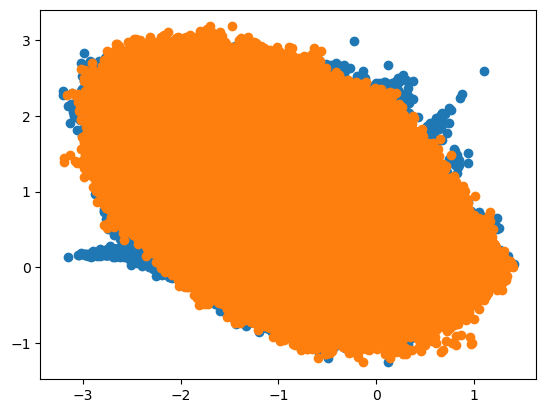

In [7]:
data_t = np.load('./data/muller/muller_brown_sim.npy')
plt.scatter(x_samples[:,0],x_samples[:,1])
plt.scatter(data_t[:,0],data_t[:,1])

In [8]:
# Muller-Brown potential parameters
A = [-200, -100, -170, 15]
a = [-1, -1, -6.5, 0.7]
b = [0, 0, 11, 0.6]
c = [-10, -10, -6.5, 0.7]
x0 = [1, 0, -0.5, -1]
y0 = [0, 0.5, 1.5, 1]

def muller_brown_potential(x, y):
    """Calculate Muller-Brown potential at point (x,y)"""
    V = 0
    for i in range(4):
        V += A[i] * np.exp(
            a[i]*(x - x0[i])**2 + 
            b[i]*(x - x0[i])*(y - y0[i]) + 
            c[i]*(y - y0[i])**2
        )
    return V

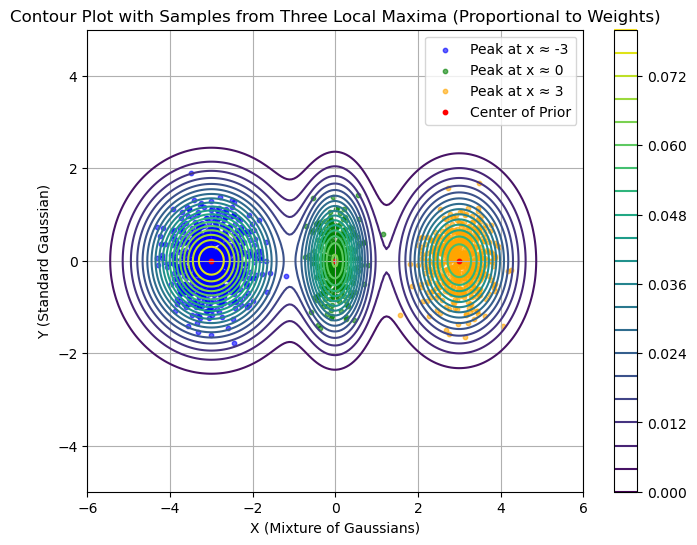

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm
g_Max = flow.mapping_from_prior(flow.Max)
# Define mixture parameters
weights_x = [0.5, 0.2, 0.3]
means_x = [-3, 0, 3]
stds_x = [1.0, 0.5, 0.8]
mean_y = 0
std_y = 1.0

# Regenerate grid
x_vals = np.linspace(-6, 6, 200)
y_vals = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x_vals, y_vals)

# Recompute P(X) and P(Y)
def mixture_gaussian_pdf(x, weights, means, stds):
    pdf = np.zeros_like(x)
    for w, mu, sigma in zip(weights, means, stds):
        pdf += w * norm.pdf(x, loc=mu, scale=sigma)
    return pdf

P_x = mixture_gaussian_pdf(X, weights_x, means_x, stds_x)
P_y = norm.pdf(Y, loc=mean_y, scale=std_y)
P_xy = P_x * P_y

# Sampling around local maxima
centers = [(-3, 0), (0, 0), (3, 0)]
std_x_local = [1.0, 0.5, 0.8]
std_y_local = [1.0, 1, 1]

total_samples = 2000  # total points to sample
n_samples_list = (np.array(weights_x) * total_samples).astype(int)

colors = ['blue', 'green', 'orange']
labels = ['Peak at x ≈ -3', 'Peak at x ≈ 0', 'Peak at x ≈ 3']

sampled_groups = []
for (center_x, center_y), std_x, std_y,n_samples in zip(centers, std_x_local, std_y_local, n_samples_list):
    samples_x = np.random.normal(loc=center_x, scale=std_x/2, size=n_samples)
    samples_y = np.random.normal(loc=center_y, scale=std_y/2, size=n_samples)
    sampled_groups.append(np.stack([samples_x, samples_y], axis=1))

# Plot
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, P_xy, levels=20)
plt.colorbar(contour)


for group, color, label in zip(sampled_groups, colors, labels):
    plt.scatter(group[:, 0], group[:, 1], color=color, s=10, alpha=0.6, label=label)
plt.scatter(flow.Max.numpy()[:,0],flow.Max.numpy()[:,1],c='red',s=10,label='Center of Prior')

plt.xlabel("X (Mixture of Gaussians)")
plt.ylabel("Y (Standard Gaussian)")
plt.title("Contour Plot with Samples from Three Local Maxima (Proportional to Weights)")
plt.legend()
plt.grid(True)
plt.show()






In [10]:
blue_pts = flow.mapping_from_prior(tf.constant(sampled_groups[0],dtype=tf.float32)).numpy()
green_pts = flow.mapping_from_prior(tf.constant(sampled_groups[1],dtype=tf.float32)).numpy()
orange_pts = flow.mapping_from_prior(tf.constant(sampled_groups[2],dtype=tf.float32)).numpy()

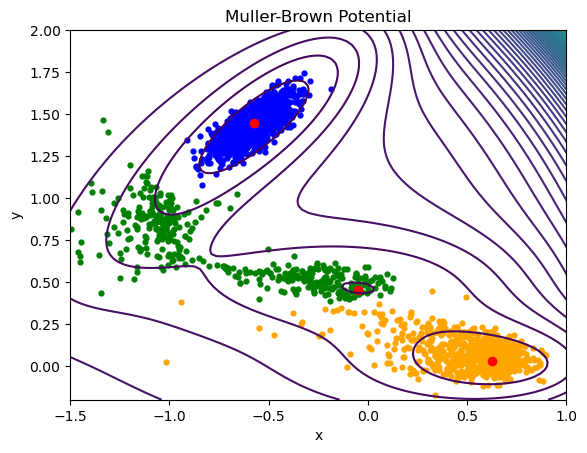

In [11]:
x = np.linspace(-1.5, 1.2, 100)
y = np.linspace(-0.2, 2.0, 100)
X, Y = np.meshgrid(x, y)
Z = muller_brown_potential(X, Y)
    
plt.contour(X, Y, Z, levels=100)
# plt.colorbar(label='Potential Energy')
# plt.scatter(-0.050, 0.466,c='r')
# plt.scatter(g_Max[:,0],g_Max[:,1])
plt.scatter(blue_pts[:,0],blue_pts[:,1],c='blue',s=12)
plt.scatter(green_pts[:,0],green_pts[:,1],c='green',s=12)
plt.scatter(orange_pts[:,0],orange_pts[:,1],c='orange',s=12)
# plt.scatter(x_target[:,0],x_target[:,1],c='r')
plt.scatter(g_Max.numpy()[:,0],g_Max.numpy()[:,1],c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Muller-Brown Potential')
plt.xlim(-1.5,1)
plt.show()